In [409]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [394]:
import numpy as np
import pandas as pd
import datetime as dt 
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [414]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc

In [415]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [416]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [417]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [418]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [419]:
# Save references to each table
measurement=Base.classes.measurement
station=Base.classes.station

In [420]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [433]:
#For personal reference
col_station = inspector.get_columns('station')
for c in col_station:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [434]:
#For personal reference
col_meas = inspector.get_columns('measurement')
for c in col_meas:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [435]:
#For personal reference
first_meas= session.query(measurement).first()
first_meas.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x28c4bbbe0>,
 'prcp': 0.08,
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397',
 'date': '2010-01-01'}

In [436]:
#For personal reference
first_station= session.query(station).first()
first_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x28c4bbb80>,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0}

# Exploratory Precipitation Analysis

In [408]:

# Find the most recent date in the data set.
session.\
        query(measurement.date).\
        order_by(measurement.date.desc()).\
        first()


('2017-08-23',)

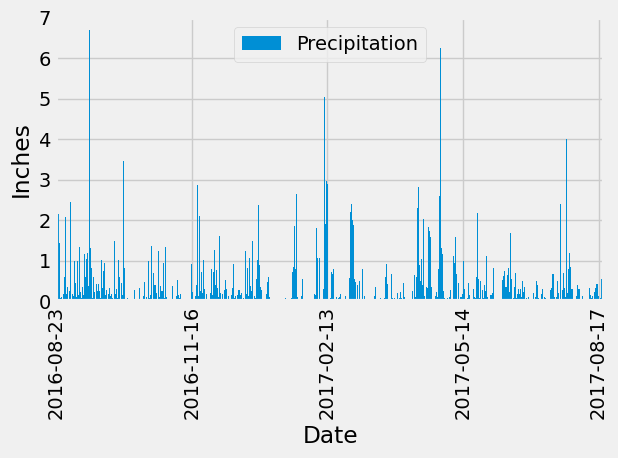

In [438]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date_tuple=session.\
        query(measurement.date).\
        order_by(measurement.date.desc()).\
        first()

most_recent_dt = datetime.strptime(most_recent_date_tuple[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
prev_year_dt = dt.date(most_recent_dt.year - 1, most_recent_dt.month, most_recent_dt.day)

# Perform a query to retrieve the data and precipitation scores
#start_
sel = [measurement.date, measurement.prcp]

precip_data = session.query(*sel).\
        filter(measurement.date >= prev_year_dt).\
        all()
precip_data

precip_df=pd.DataFrame(precip_data,columns=['Date',"Precipitation"])
precip_df = precip_df.dropna(how='any') # clean up non value entries

# Sort the dataframe by date
precip_df=precip_df.sort_values(["Date"], ascending=True)
precip_df=precip_df.set_index("Date")

# Use Pandas Plotting with Matplotlib to plot the data
ax = precip_df.plot.bar(rot=90, width=3)
tick_frequency = 500

ax.set_ylim(0, 7)
ticks = ax.get_xticks()
labels = ax.get_xticklabels()
ax.set_ylabel('Inches')

# Set the new tick locations and labels
ax.set_xticks(ticks[::tick_frequency])
ax.set_xticklabels(labels[::tick_frequency], rotation=90)

plt.tight_layout()
plt.show()


In [341]:
precip_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


In [243]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [424]:
# Design a query to calculate the total number of stations in the dataset
session.query(station.name.distinct()).count() 

9

In [425]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel=[measurement.station,func.count(measurement.date)]
station_activity = session.query(*sel).\
    group_by(measurement.station).\
    order_by(func.count(measurement.date).desc()).all()
station_activity  

   

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [426]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#'USC00519281', 2772
sel=[func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]
USC00519281_temp = session.query(*sel).\
                        filter(measurement.station == 'USC00519281').all()
                       

#measurement.station,

# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [func.count(measurement.tobs), measurement.tobs]

USC00519281_temp_freq = session.query(*sel).\
        filter((measurement.date >= prev_year_dt) & (measurement.station == "USC00519281")).\
        group_by(measurement.tobs).\
        order_by(measurement.tobs).\
        all()
USC00519281_temp_freq

#create dataframe
USC00519281_temp_freq_df=pd.DataFrame(
                        USC00519281_temp_freq,
                        columns=["Counts","Temperature"])
USC00519281_temp_freq_df = USC00519281_temp_freq_df.dropna(how='any') # clean up non value entries

#USC00519281_temp_freq_df.plot.hist(y='Temperature', bins=12, alpha=0.7, edgecolor='black')
USC00519281_temp_freq_df.plot.hist()
plt.show()

Text(0.5, 0, 'Temperature')

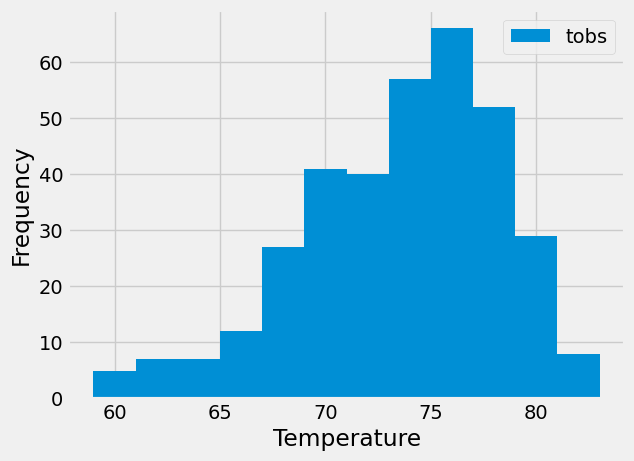

In [441]:
#station_highest_obs = station_activity[0][0]

USC00519281_temp_freq = session.query(measurement.date, measurement.tobs).\
                        filter(measurement.station == 'USC00519281').\
                        filter(measurement.date >= "prev_year_dt").all()

# convert to dataframe
USC00519281_temp_freq_df = pd.DataFrame(results)

# historgram
ax=USC00519281_temp_freq_df.plot.hist(bins=12)
ax.set_xlabel('Temperature')

In [428]:
USC00519281_temp_freq_df.head()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


# Close Session

In [319]:
# Close Session
session.close()